In this activity, we will build a movie search engine that finds similar movie lines to the
one provided by the user. We will make use of the Doc2Vec model, which we saw in the
earlier exercise.

1. Import the necessary libraries.
2. Load the movie lines file.
3. Iterate over each movie line and split the columns.
4. Create a DataFrame and load the Doc2Vec model.
5. Create a function that converts the sentences into vectors.
6. Create another function that does the similarity checks.
7. Test both the functions.
After implementing these steps, the expected output should look as follows:
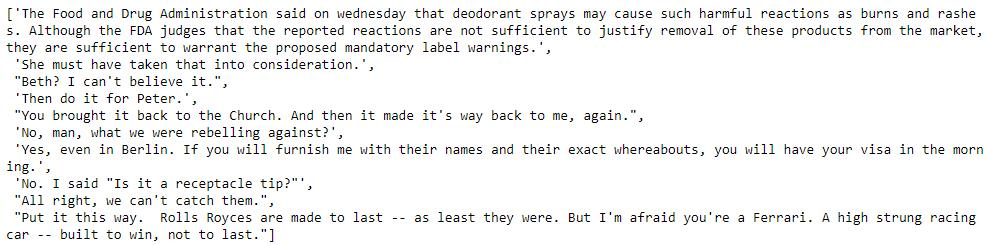
Figure : Result of running the similar_movie_lines function on a sample line

In [2]:
import pandas as pd
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords
import random 

import warnings 
warnings.filterwarnings("ignore")

pd.set_option

In [62]:
from pathlib import Path 
import re

movie_lines_file = Path(r'dataset\cornell-movie-dialogs\movie_lines.txt')

with movie_lines_file.open() as f:
    movie_lines = [line.strip().split('+++$+++') for line in f.readlines()]

In [63]:
lines_df = pd.DataFrame([{'LineNumber': d[0].strip(), 
                                'Person': d[3].strip(),
                                'Line': d[4].strip(),
                                 'Movie' : d[2].strip()} 
                              for d in movie_lines])
lines_df = lines_df.set_index('LineNumber')

In [64]:
lines_df.head(10)

,Person,Line,Movie
LineNumber,,,
L1045,BIANCA,They do not!,m0
L1044,CAMERON,They do to!,m0
L985,BIANCA,I hope so.,m0
L984,CAMERON,She okay?,m0
L925,BIANCA,Let's go.,m0
L924,CAMERON,Wow,m0
L872,BIANCA,Okay -- you're gonna need to learn how to lie.,m0
L871,CAMERON,No,m0
L870,BIANCA,I'm kidding. You know how sometimes you just ...,m0


In [6]:
len(lines_df)

304713

In [7]:
lines_df.nunique()

Person      5356
Line      265786
Movie        617
dtype: int64

In [8]:
lines_df_small = lines_df.head(30000)

In [9]:
from gensim.utils import simple_preprocess

In [10]:
def text_to_tokens(text):
    text = text.lower()
    text = remove_stopwords(text)
    tokens = simple_preprocess(text)
    return tokens

In [11]:
class DocumentDataset(object):
    
    def __init__(self, data:pd.DataFrame, column):
        document = data[column].apply(self.preprocess)
        self.documents = [ TaggedDocument( text, [index]) 
                          for index, text in document.iteritems() ]
      
    def preprocess(self, document):
        return preprocess_string(remove_stopwords(document))
        
    def __iter__(self):
        for document in self.documents:
            yield documents
            
    def tagged_documents(self, shuffle=False):
        if shuffle:
            random.shuffle(self.documents)
        return self.documents

In [12]:
documents_dataset = DocumentDataset(lines_df_small, 'Line')

## Document Vector Model


In [17]:
docVecModel = Doc2Vec(min_count=1, window=5, vector_size=100, sample=1e-4, negative=5, workers=8)
docVecModel.build_vocab(documents_dataset.tagged_documents())

In [65]:
docVecModel.train(documents_dataset.tagged_documents(shuffle=True),total_examples=docVecModel.corpus_count,epochs=50)

In [ ]:
docVecModel.corpus_count

In [ ]:
docVecModel.save('models/MovieLinesModel.d2v')

In [ ]:
docVecModel.load('models/MovieLinesModel.d2v')

In [ ]:
docVecModel['L872']

In [21]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def show_image(vector, line):
    fig, ax = plt.subplots(1,1, figsize=(10, 2))
    ax.tick_params(axis='both', 
                   which='both',
                   left=False, 
                   bottom=False, 
                   top=False,
                   labelleft=False, 
                   labelbottom=False)
    ax.grid(False)
    print(line)
    ax.bar(range(len(vector)), vector, 0.5)
   
    
def show_movie_line(line_number):
    line = lines_df_small.loc[line_number].Line
    doc_vector = docVecModel.docvecs[line_number]
    show_image(doc_vector, line)
    

Okay -- you're gonna need to learn how to lie.


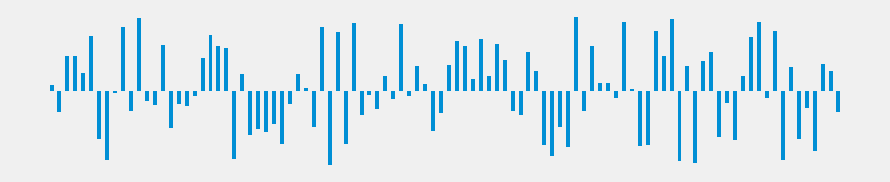

In [22]:
show_movie_line('L872')

In [ ]:
# !pip  install --user numpy==1.19.5

In [19]:
docVecModel.docvecs.most_similar('L872')

[('L60168', 0.365919291973114),
 ('L172145', 0.36009523272514343),
 ('L31064', 0.351371705532074),
 ('L60802', 0.3446563184261322),
 ('L6882', 0.33654695749282837),
 ('L6745', 0.3361952304840088),
 ('L172072', 0.33282336592674255),
 ('L19029', 0.3300164043903351),
 ('L152117', 0.3250901401042938),
 ('L30574', 0.32291415333747864)]

In [23]:
def to_vector(sentence):
    cleaned = preprocess_string(sentence)
    docVector = docVecModel.infer_vector(cleaned)
    return docVector

Okay -- you're gonna need to learn how to lie.


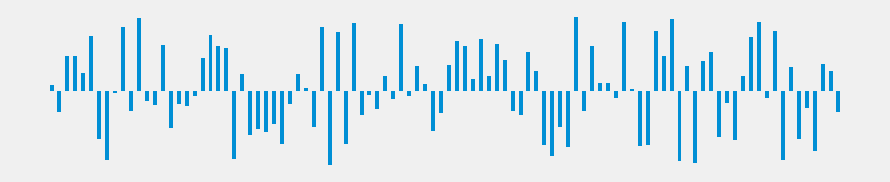

In [24]:
show_movie_line('L872')

you're gonna need to learn not to tell lies


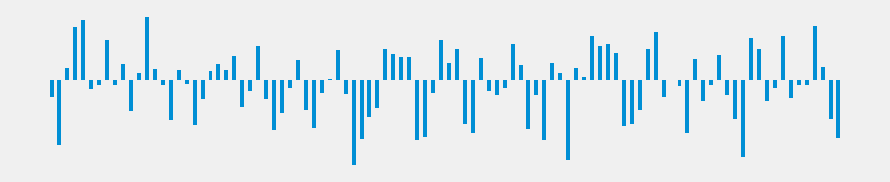

In [25]:
line = "you're gonna need to learn not to tell lies"
show_image(to_vector("you're gonna need to learn how to lie"), line)

In [60]:
def similar_movie_lines(sentence):
    vector = to_vector(sentence)
    similar_vectors = docVecModel.docvecs.most_similar(positive=[vector])
    similar_lines = [ lines_df.loc[line[0]].Line for line in similar_vectors]
    return similar_lines


In [68]:
similar_movie_lines("ll")

['...Hi.',
 'Hi.',
 'Yes.',
 'Holy shit.',
 'Only sailors use condoms, man.',
 "Oh, lawyers are so complicated-don't do that. Here.",
 "Pressure?  DeLa, you don't know what the hell real pressure is. SHEEETT!!!  This is lightstuff. Now when you scramblin' out on the street in da January winter and the hawk is talkin' to you with NO money and NO prospects of money anytime soon, now that there is some pressure.",
 "Where's Mandalay?",
 'Sounds good, Talby. Let me know if anything important comes up.',
 'Where is he, Donald?']

In [69]:
lines_df_small.loc['L59293'].Line

'Okay, ten thousand plus a G.E. toaster oven, a Litton microwave, a Cuisinart...'

In [ ]:

def main():
    print("Welcome to the Movie Line Search Engine!")
    
    while True:
        user_input = input("Enter a movie line (or type 'exit' to quit): ")
        
        if user_input.lower() == 'exit':
            print("Goodbye!")
            break
        
        similar_lines = similar_movie_lines(user_input)
        
        print("\nSimilar movie lines:")
        for idx, line in enumerate(similar_lines, start=1):
            print(f"{idx}. {line}")
        print()

if __name__ == "__main__":
    main()